# Yeast cells detection evaluation notebook

Evaluates the performance of segmentation and tracking on the YIT ground truth data set. 

Performances are displayed as calibration curves over the `segmentation_threshold`, and as a calibration heatmap over the tracking hyperparameters `dmax` and `epsilon`.

In [ ]:
try:
  from yeastcells import data, yit, segmentation, tracking, evaluation
except ImportError:
  # Outside of colab, it is necesary to manually install scikit-learn, seaborn, torch and torchvision, e.g.:
  # !pip3 install scikit-learn torch torchvision seaborn
  !pip3 install -U pyyaml # resolves: FileNotFoundError: [Errno 2] No such file or directory: '/usr/local/lib/python3.7/dist-packages/PyYAML-3.13.dist-info/METADATA
  !pip3 install -U git+https://github.com/ymzayek/yeastcells-detection-maskrcnn.git
  from yeastcells import data, yit, segmentation, tracking, evaluation

In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from download import download
from skimage.io import imread
from itertools import product
import matplotlib.pyplot as plt
from multiprocessing import Pool
from scipy.sparse import coo_matrix
from sklearn.exceptions import EfficiencyWarning

%matplotlib inline

In [3]:
# Tested thresholds
thresholds = np.arange(.8, 1, 0.005)

# Tested hyperparameter values for tracking
dmaxs = np.arange(2, 7, 1)
epsilons = np.arange(0.35, 0.91, 0.05)

# Selected threshold
segmentation_threshold=0.955

testset_names = [
 'TestSet1',
 'TestSet2',
 'TestSet3',
 'TestSet4',
 'TestSet5',
 'TestSet6',
 'TestSet7',
#  'TestSet8',
#  'TestSet9',
#  'TestSet10',
]

## Download model and data

In [4]:
pipeline_path = f'./yeastcells-detection-maskrcnn'
model_filename = f'{pipeline_path}/model_final.pth'

download(
    'https://datascience.web.rug.nl/models/yeast-cells/mask-rcnn/v1/model_final.pth', model_filename)

download(
    'https://datascience.web.rug.nl/YeaZ_results.zip',
    f'{pipeline_path}/YeaZ_results/YeaZ_results.zip')

download(
    'https://datascience.web.rug.nl/YIT-Benchmark2.zip', 
    f'{pipeline_path}/YIT-Benchmark2/YIT-Benchmark2.zip')

!cd '{pipeline_path}' && unzip -o -qq 'YIT-Benchmark2/YIT-Benchmark2.zip' -d YIT-Benchmark2
!cd '{pipeline_path}' && unzip -o -qq 'YeaZ_results/YeaZ_results.zip' -d YeaZ_results

# We've precomputed the outcomes of the YeaZ model on the YIT data
def load_test_yeaz_detections(path, testset_name = 'TestSet1'):
  # one mask per frame, with integer encoded segmentation.
  masks = data.read_tiff_mask(f'{path}/YeaZ_results/YeaZ_masks_{testset_name}.tiff')

  # a dataframe with every detection per frame seperately
  yeaz_detections = pd.DataFrame([
    {'frame': frame, 'cell': cell}
    for frame, mask in enumerate(masks)
    for cell in np.unique(mask)
    if cell > 0
  ])

  # create one-hot encoded masks, like we get from the Mask-RCNN, such that they
  # fit our evaluation pipeline.
  masks = (
      masks[yeaz_detections['frame']] # repeat frames per detection of a frame
      == yeaz_detections['cell'].values[:, None, None] # one-hot encode
  )
  # we could use the dataframe's index, but a seperate column is safer to mutations
  yeaz_detections['mask'] = np.arange(len(masks))
  return masks, yeaz_detections


file_sizes: 100%|████████████████████████████| 351M/351M [00:12<00:00, 28.0MB/s]
Successfully downloaded file to ./yeastcells-detection-maskrcnn/model_final.pth

file_sizes: 100%|██████████████████████████| 1.21M/1.21M [00:00<00:00, 2.36MB/s]
Successfully downloaded file to ./yeastcells-detection-maskrcnn/YeaZ_results/YeaZ_results.zip

file_sizes: 100%|████████████████████████████| 263M/263M [00:09<00:00, 27.0MB/s]
Successfully downloaded file to ./yeastcells-detection-maskrcnn/YIT-Benchmark2/YIT-Benchmark2.zip


## Performance

### YeaZ vs. our Mask R-CNN pipeline

Comparing YeaZ and our model w.r.t. different metrics. We've used different thresholds per test set, as shown in the section 'Segmentation theshold optimization'. We've also determined general values for dmax and epsilon below.

In [5]:
optimal_thresholds = {
    'TestSet1': 0.955, 'TestSet2': 0.975, 'TestSet3': 0.9, 'TestSet4': 0.9,
    'TestSet5': 0.9, 'TestSet6': 0.9, 'TestSet7': 0.9}

In [6]:
metrics = []
import time

for testset_name in tqdm(testset_names, desc='Overall evaluation progress'):
  image = yit.get_test_movie(pipeline_path, testset_name)
  
  ground_truth = yit.get_ground_truth(pipeline_path, testset_name)
  
  # YeaZ results
  yeaz_masks, yeaz_detections = load_test_yeaz_detections(pipeline_path, testset_name)
  
  # Mask R-CNN results
  threshold = optimal_thresholds[testset_name]
  maskrcnn_detections, maskrcnn_masks = segmentation.get_segmentation(
      image, model_filename, seg_thresh=threshold, device='cuda:0')
  
  # Tracking Mask R-CNN results via DBSCAN clustering
  maskrcnn_detections = tracking.track_cells(maskrcnn_detections, maskrcnn_masks,
                                             dmax=5, min_samples=3, eps=0.6, device='cuda:0')
  
  metrics.extend([
      {'test set': testset_name, 'task': task, 'model': model,
       'metric': metric, 'value': value}
      for task, get_metrics in {
          'tracking': evaluation.get_tracking_metrics,
          'segmentation': evaluation.get_segmention_metrics}.items()
      for model, detections, masks in [
        ('YeaZ', yeaz_detections, yeaz_masks),
        ('Mask R-CNN', maskrcnn_detections, maskrcnn_masks),
      ]
      for metric, value in evaluation.calculate_metrics(get_metrics(
        ground_truth, detections, masks)).items()
  ])

results = pd.DataFrame(metrics)

In [7]:
results.pivot(('test set', 'model'), columns=('task', 'metric'), values='value')

task                 tracking                      ... segmentation                    
metric               F1-score  Accuracy Precision  ...     Accuracy Precision    Recall
test set model                                     ...                                 
TestSet1 Mask R-CNN  0.927329  0.864505  0.942029  ...     0.843725  0.913675  0.916810
         YeaZ        0.793419  0.657576  0.679825  ...     0.646002  0.665672  0.956261
TestSet2 Mask R-CNN  0.966543  0.935252  1.000000  ...     0.925676  0.978571  0.944828
         YeaZ        0.658354  0.490706  0.503817  ...     0.466443  0.476027  0.958621
TestSet3 Mask R-CNN  0.861053  0.756007  0.991515  ...     0.830065  0.993740  0.834428
         YeaZ        0.901415  0.820523  0.884857  ...     0.857882  0.903943  0.943933
TestSet4 Mask R-CNN  0.527358  0.358103  0.986034  ...     0.478907  0.999000  0.479137
         YeaZ        0.865415  0.762759  0.898929  ...     0.836032  0.944602  0.879137
TestSet5 Mask R-CNN  0.710526  0.551020  0.977081  ...     0.626837  0.981000  0.634541
         YeaZ        0.839445  0.723313  0.868189  ...     0.779333  0.907735  0.846378
TestSet6 Mask R-CNN  0.897616  0.814249  1.000000  ...     0.860987  0.989691  0.868778
         YeaZ        0.915475  0.844125  0.936170  ...     0.882609  0.957547  0.918552
TestSet7 Mask R-CNN  0.687800  0.524158  0.983516  ...     0.640413  0.992000  0.643738
         YeaZ        0.943509  0.893059  0.956027  ...     0.927757  0.975350  0.950032

[14 rows x 8 columns]

### Segmentation theshold optimization

In [8]:
metrics = []

for testset_name in tqdm(testset_names, desc='Overall evaluation progress'):
  image = yit.get_test_movie(pipeline_path, testset_name)
  ground_truth = yit.get_ground_truth(pipeline_path, testset_name)
  
  # Mask R-CNN results
  maskrcnn_detections, maskrcnn_masks = segmentation.get_segmentation(
      image, model_filename, seg_thresh=float(thresholds.min()), device='cuda:0')
  
  for i, threshold in enumerate(tqdm(thresholds,
                                     desc=f'Progress for {testset_name}',
                                     leave=False)):
    
    # Filter out detections according to threshold.
    above_threshold = maskrcnn_detections['segmentation_score'] >= threshold
    maskrcnn_detections_above_threshold = maskrcnn_detections[above_threshold].copy()
    
    # Tracking Mask R-CNN results via DBSCAN clustering
    maskrcnn_detections_above_threshold = tracking.track_cells(
      maskrcnn_detections_above_threshold, maskrcnn_masks,
      dmax=5, min_samples=3, eps=0.6, device='cuda:0')
    
    metrics.extend([
        {'test set': testset_name, 'task': task, 'metric': metric,
         'value': value, 'threshold': threshold, 'model': 'Mask R-CNN'}
        for task, get_metrics in {
            'tracking': evaluation.get_tracking_metrics,
            'segmentation': evaluation.get_segmention_metrics}.items()
        for metric, value in evaluation.calculate_metrics(get_metrics(
          ground_truth, maskrcnn_detections_above_threshold, maskrcnn_masks
        )).items()
    ])
threshold_results = pd.DataFrame(metrics)

#### Results

The performance of segmentation and tracking shown as calibration curves with respect to the threshold

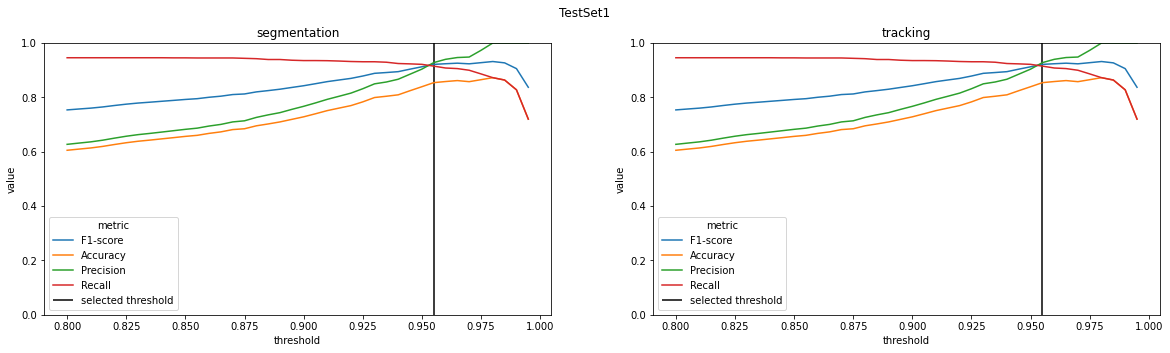

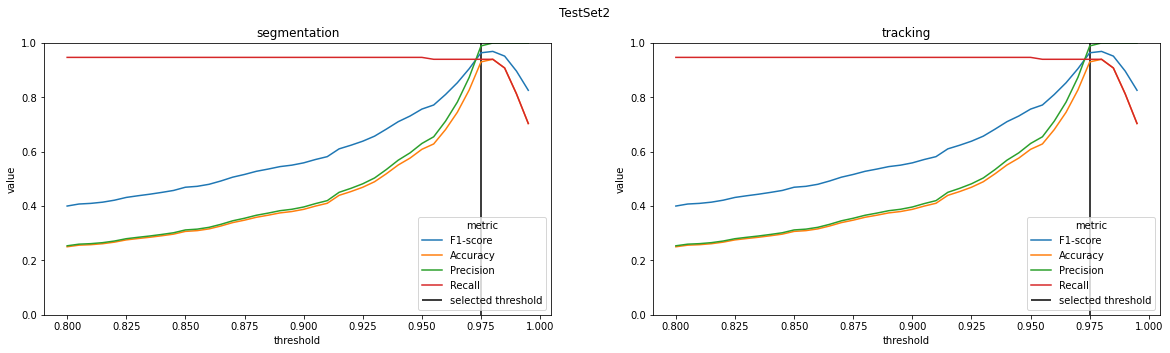

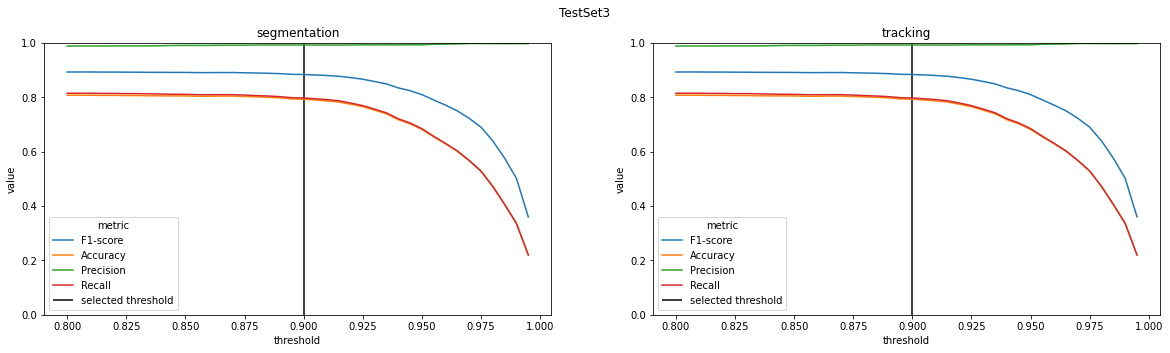

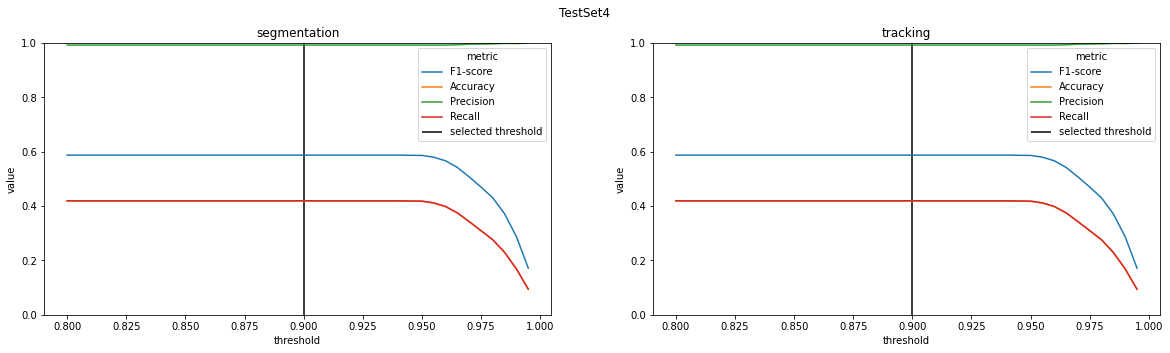

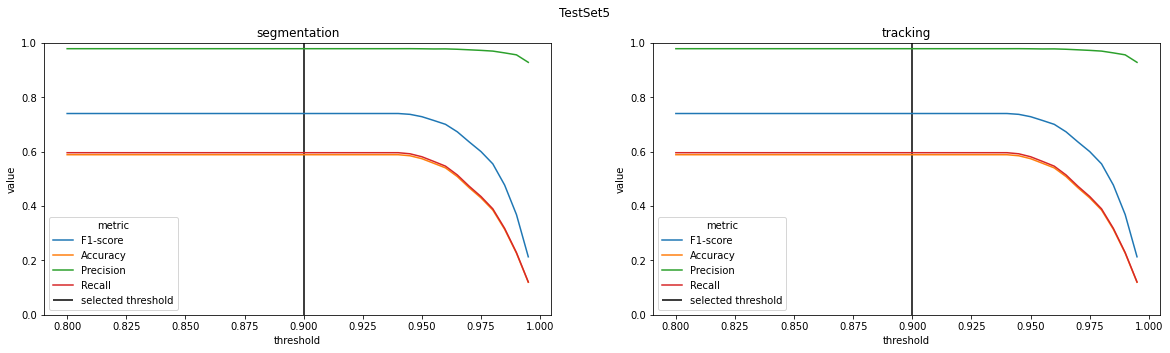

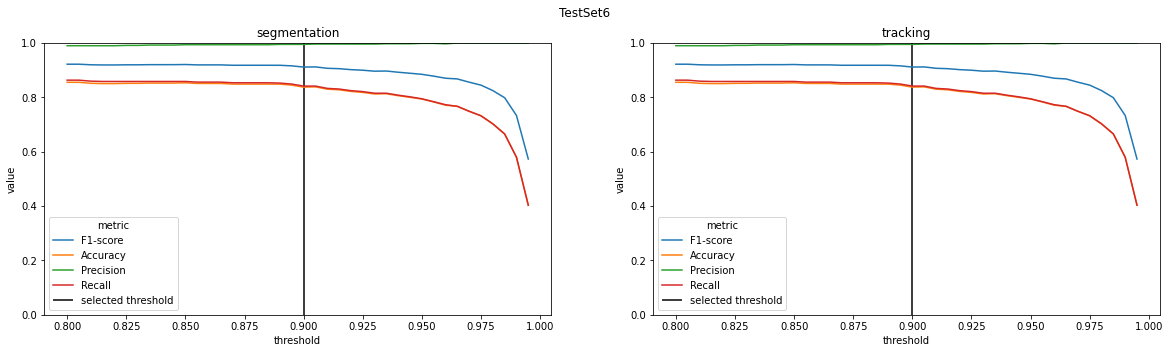

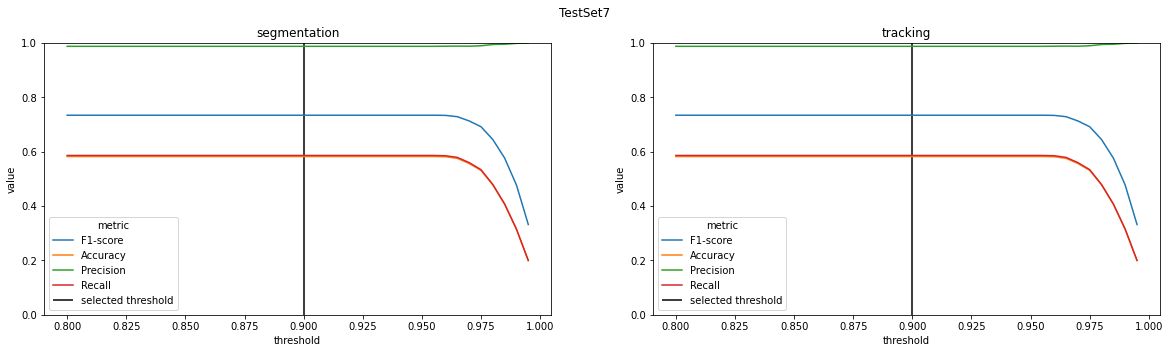

In [9]:
for testset_name, testset_results in tqdm(threshold_results.groupby('test set')):
  fig, axes = plt.subplots(1, 2, figsize=(20, 5))
  for (task, task_results), axis in zip(testset_results.groupby('task'), axes.ravel()):
    optimal_threshold = optimal_thresholds[testset_name]
    axis.vlines(optimal_threshold, 0, 1, label='selected threshold')
    
    sns.lineplot(data=testset_results, x='threshold', y='value', hue='metric', ax=axis, ci=None)
    axis.set_title(task); axis.set_ylim(0, 1)
  plt.suptitle(testset_name)

#### Export

Export as spreadsheet.

In [10]:
threshold_results.pivot(index=['threshold'],
                        columns=['test set', 'task', 'metric'],
                        values='value').to_excel('threshold-tuning-results.xlsx')

try:
  from google.colab.files import download
  download('threshold-tuning-results.xlsx')
except ImportError:
  print('Not on Google Colab, won\'t start download')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Tuning `dmax` and `epsilon` hyperparameters for tracking

In [11]:
metrics = []

import time

for testset_name in tqdm(testset_names, desc='Overall evaluation progress'):
  image = yit.get_test_movie(pipeline_path, testset_name)
  ground_truth = yit.get_ground_truth(pipeline_path, testset_name)
  
  # Mask R-CNN results
  threshold = optimal_thresholds[testset_name]
  maskrcnn_detections, maskrcnn_masks = segmentation.get_segmentation(
      image, model_filename, seg_thresh=threshold, device='cuda:0')
  
  for dmax in tqdm(dmaxs, desc=f'Progress for {testset_name}', leave=False):
    # Distances only depend on dmax, and hence can be reused for all epsilons
    t0 = time.time()
    distances = tracking.get_distances(maskrcnn_detections, maskrcnn_masks,
                                       dmax=dmax, device='cuda:0')
    
    for epsilon in epsilons:
      # Tracking Mask R-CNN results via DBSCAN clustering
      t0 -= time.time()
      maskrcnn_detections = tracking.track_cells(
        maskrcnn_detections, maskrcnn_masks,
        dmax=dmax, min_samples=3, eps=epsilon, device='cuda:0',
        distances = distances)
      
      metrics.extend([
        {'test set': testset_name, 'task': task, 'model': 'Mask R-CNN',
         'threshold': threshold, 'dmax': dmax, 'eps': epsilon,
         'metric': metric, 'value': value}
        for task, get_metrics in {
            'tracking': evaluation.get_tracking_metrics,
            # 'segmentation': evaluation.get_segmention_metrics,
            }.items()
        for metric, value in evaluation.calculate_metrics(get_metrics(
          ground_truth, maskrcnn_detections, maskrcnn_masks
        )).items()
      ])

tracking_results = pd.DataFrame(metrics)

#### Results

Several performance metrics represented by bars or a heatmap for different `eps` and `dmax` values.

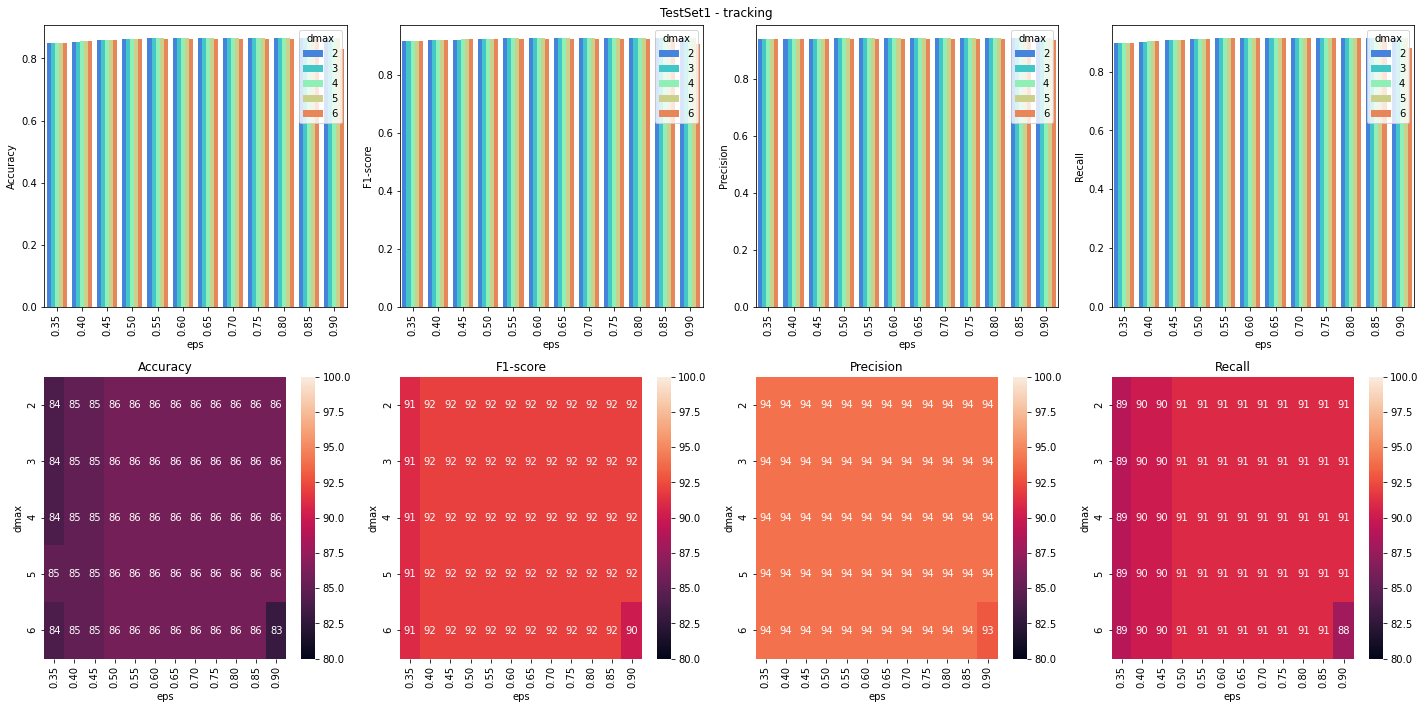

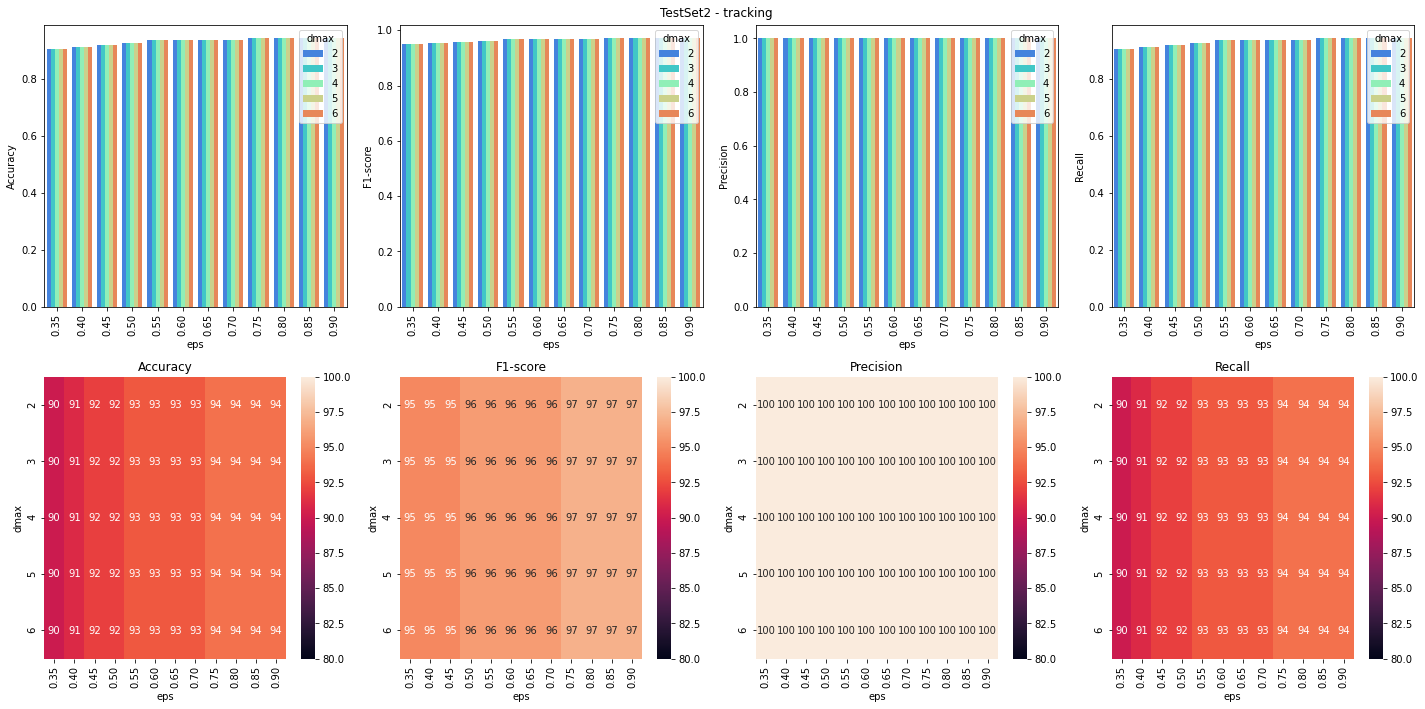

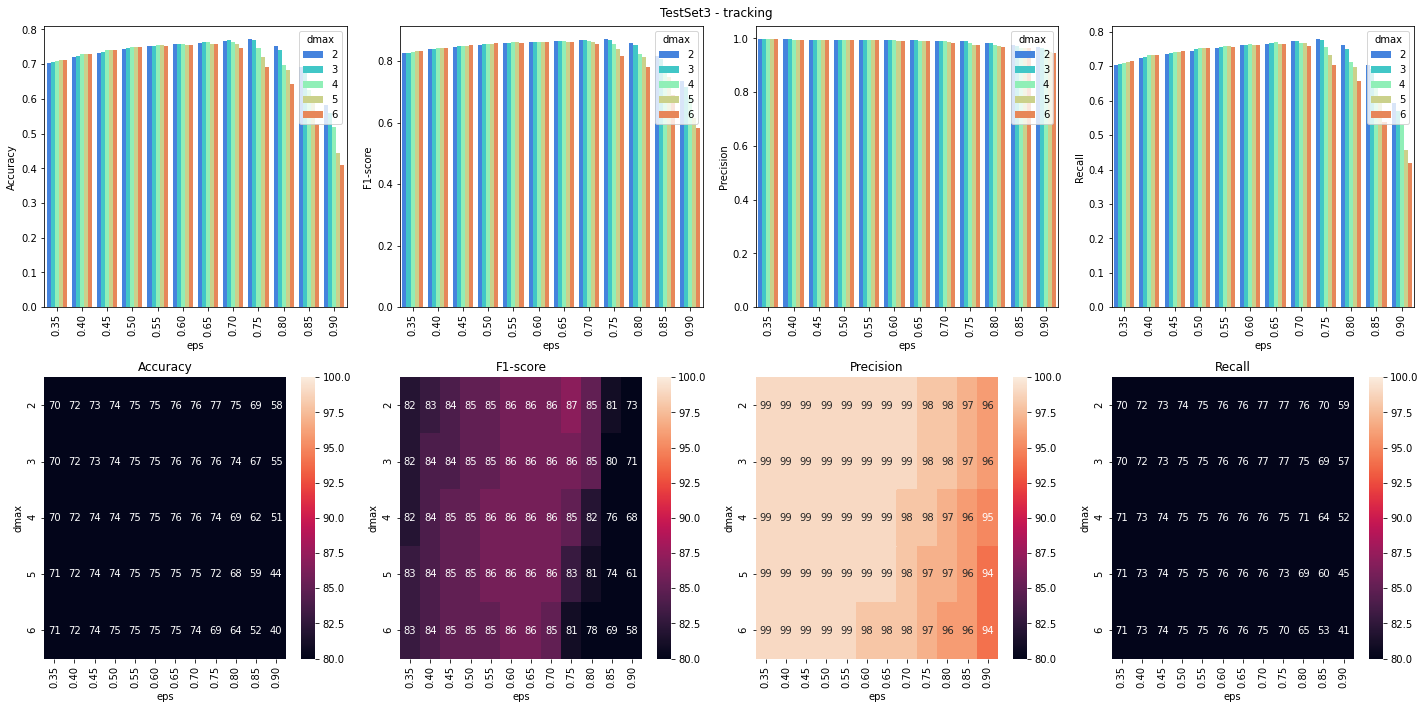

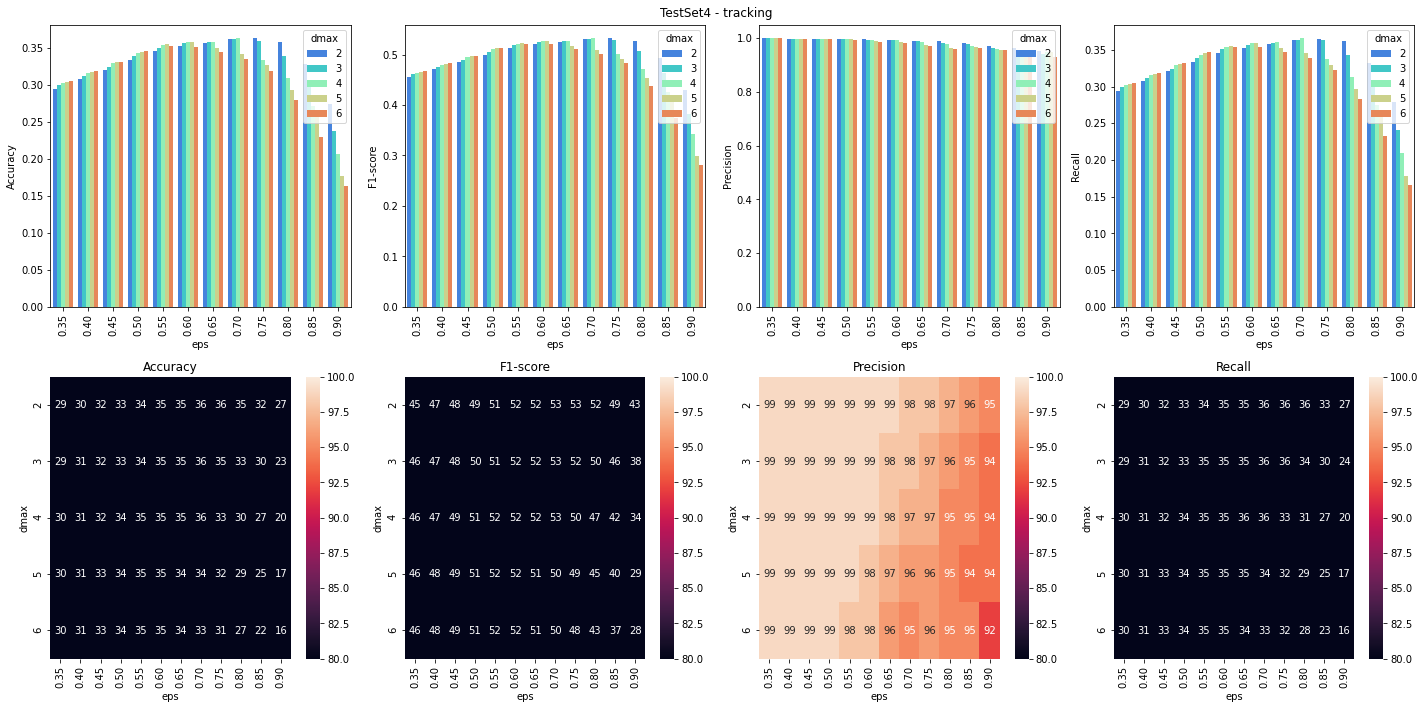

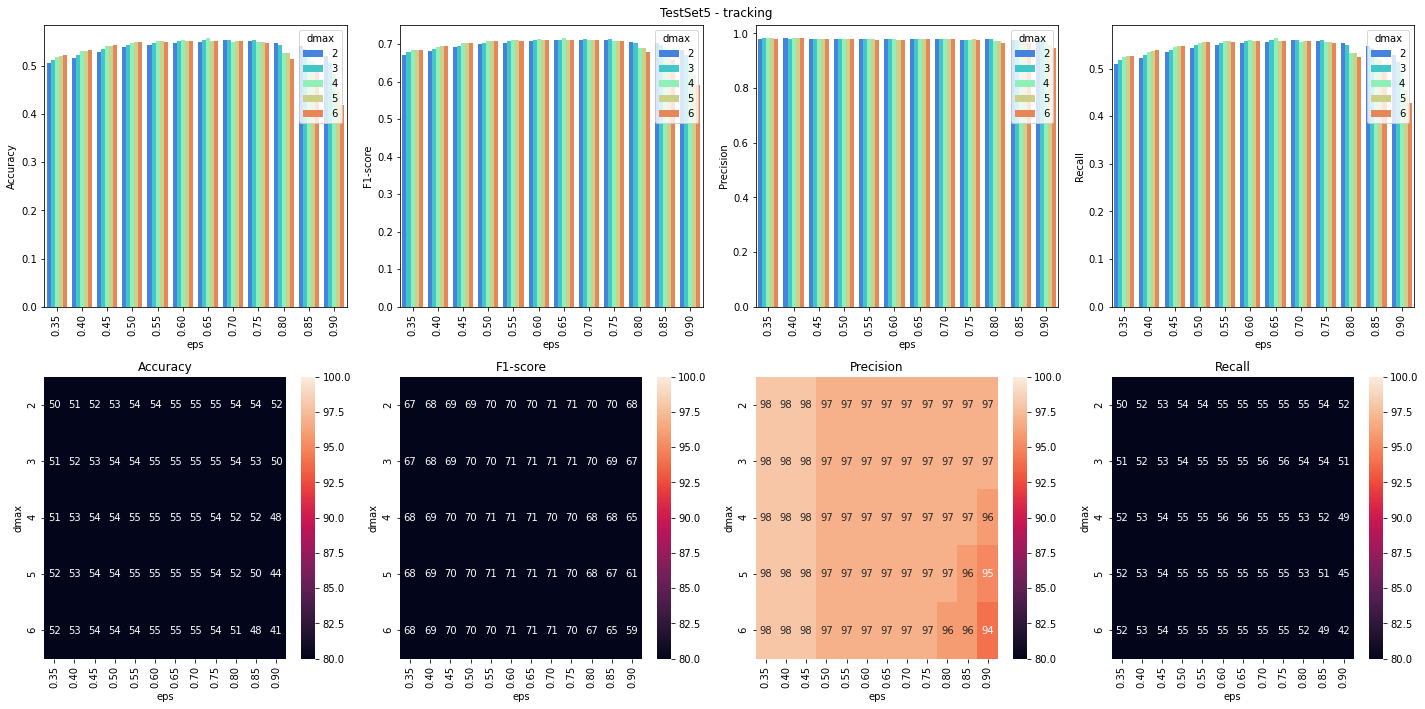

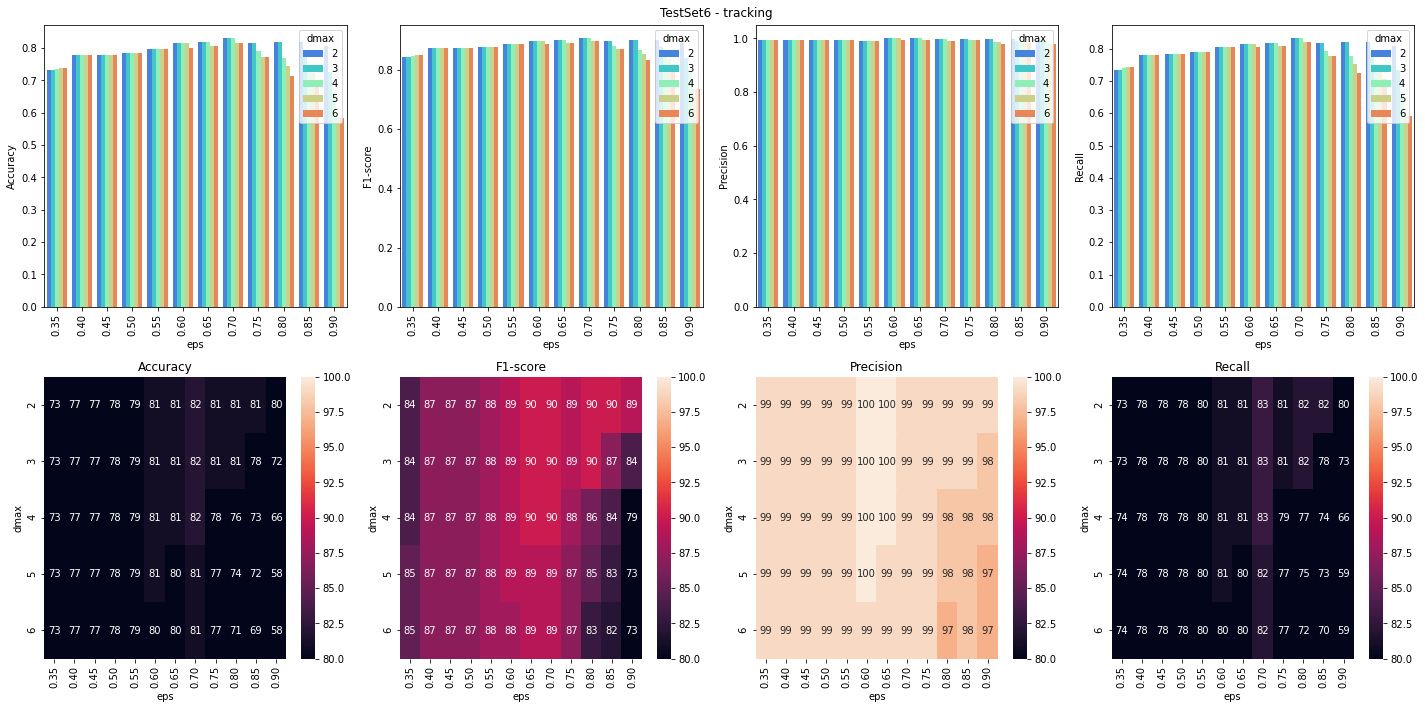

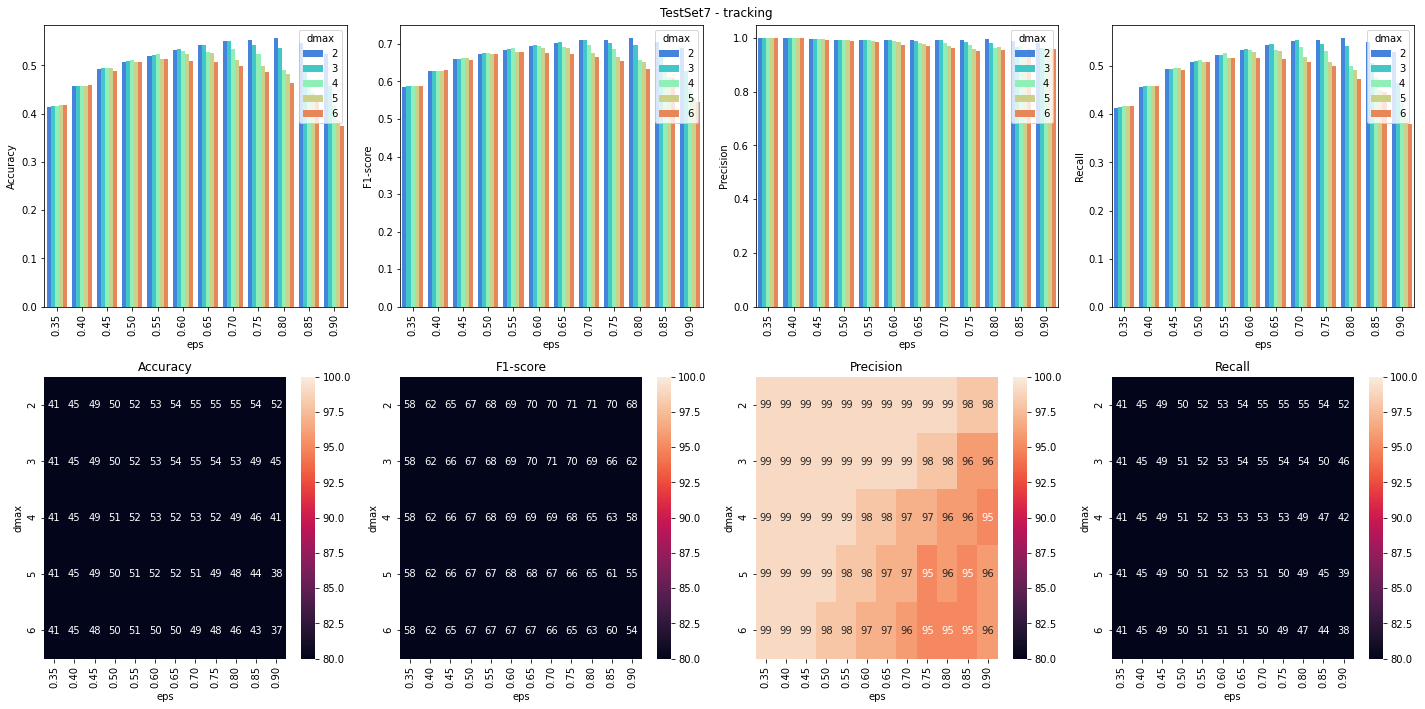

In [12]:
%matplotlib inline


for (testset_name, task), set_task_rows in tqdm(tracking_results.groupby(['test set', 'task'])):
  fig, axes = plt.subplots(2, 4, figsize=(20, 10))
  for (metric, rows), (ax0, ax1) in zip(set_task_rows.groupby('metric'), axes.T):
    rows = rows.rename({'value': metric}, axis=1)
    sns.barplot(data=rows.rename({'value': metric}, axis=1),
                hue='dmax', x='eps', y=metric, palette='rainbow', ax=ax0)
    ax0.set_xticklabels([f'{eps:0.2f}' for eps in epsilons], rotation=90)
    ax1.set_ylim(0, 1)

    # Show as pecentages
    rows = (100 * rows.pivot('dmax', columns=['eps'], values=metric)).astype(int)
    sns.heatmap(data=rows, annot=True, ax=ax1, vmin=80, vmax=100, fmt='d')
    ax1.set_xticklabels([f'{eps:0.2f}' for eps in epsilons], rotation=90)
    ax1.set_title(metric)
  plt.tight_layout(rect=(0, 0, 1, 0.97)) # allow some space for the main title
  fig.suptitle(f'{testset_name} - {task}')

#### Export

Save and download these results as a spreadsheets.

In [13]:
tracking_results.pivot(
  index=['test set', 'dmax', 'eps'],
  columns=['task', 'metric'], values='value').to_excel('tracking-tuning-results.xlsx')

try:
  from google.colab.files import download
  download('tracking-tuning-results.xlsx')
except ImportError:
  print('Not on Google Colab, won\'t start download')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Acountability of False Positives and Negatives

Illustrates whether segentation or tracking causes the tracking errors. Ideally, one would compare tracking performance on the segmetation output and the ground truth segmentation, to empirically establish the cause. However, the YIT ground truths do not contain segmentations, but rather coordinates, and hence can't be used as input for tracking.

The `get_tracking_metrics` does not just report false negatives, positives and true positives, but also the cause of these false negatives and positives.

Note that false negatives and true positives partition the following set of ground truths in adjacent frames with the same label:

$S_1 = \{(a, b) \vert a, b \in \textrm{ground truth}, a\neq b,\;frame(a)=frame(b)+1,\; label(a) = label(b)\}$

Where $label$ is the tracking label assigned by the ground truth. The false negatives are those for which

 * Mask-RCNN segmentation didn't detect either $a$ or $b$ (segmentation column), or else
 * Tracking marked either or both $a$ or $b$ as an outlier (untracked column), or else
 * Tracking did not assign the same label to $a$ and $b$ (poor tracking column)

A similar set over partitions the false positives and true positives of detections in adjacent frames with the same tracking label:

$S_2 = \{(a, b) \vert a, b \in \textrm{detections},\;a\neq b,\;frame(a)=frame(b)+1,\;\hat{label}(a) = \hat{label}(b)\}$

Where $\hat{label}$ is the tracking label assigned by the algorithm. In this case the false positives can be classified 
 * Either or both $a$ and $b$ were not in the ground truth (segmentation column), or else
 * The ground truth did not assign the same label to $a$ and $b$ (poor tracking column).

Due to this partitioning, the false positives and negatives can be accounted to either segmention errors, tracking ourliers or a tracking mistake.



In [14]:
metrics = []
import time

for testset_name in tqdm(testset_names, desc='Overall evaluation progress'):
  image = yit.get_test_movie(pipeline_path, testset_name)
  
  ground_truth = yit.get_ground_truth(pipeline_path, testset_name)
  
  # YeaZ results
  yeaz_masks, yeaz_detections = load_test_yeaz_detections(pipeline_path, testset_name)
  
  # Mask R-CNN results
  threshold = optimal_thresholds[testset_name]
  maskrcnn_detections, maskrcnn_masks = segmentation.get_segmentation(
      image, model_filename, seg_thresh=threshold, device='cuda:0')
  
  # Tracking Mask R-CNN results via DBSCAN clustering
  maskrcnn_detections = tracking.track_cells(maskrcnn_detections, maskrcnn_masks,
                                             dmax=5, min_samples=3, eps=0.6, device='cuda:0')
  
  metrics.extend([
      {'test set': testset_name, 'task': task, 'model': model,
       'metric': metric, 'value': value}
      for task, get_metrics in {
          'tracking': evaluation.get_tracking_metrics,}.items()
      for model, detections, masks in [
        ('Mask R-CNN', maskrcnn_detections, maskrcnn_masks),
      ]
      for metric, value in get_metrics(
        ground_truth, detections, masks).items()
  ])

tracking_acounting_results = pd.DataFrame(metrics)

#### Results

In [15]:
tracking_results_table = tracking_acounting_results.pivot('test set', 'metric', 'value')

fn = 'false negatives'
fp = 'false positives'
tracking_acounting = pd.DataFrame({
    (fn, '#'): 0,
    (fn, 'segmentation'): 100 * tracking_results_table['segmentation fn'] /
                                tracking_results_table['fn'],
    (fn, 'untracked'):    100 * tracking_results_table['untracked fn'] /
                               tracking_results_table['fn'],
    (fn, 'poor tracking'): 0,
    (fp, '#'): 0,
    (fp, 'segmentation'): 100 * tracking_results_table['segmentation fp'] /
                                tracking_results_table['fp'],
    (fp, 'poor tracking'): 0,
          
}).round(3)

tracking_acounting[(fn, 'poor tracking')] = 100 - tracking_acounting[fn].sum(1)
tracking_acounting[(fp, 'poor tracking')] = 100 - tracking_acounting[fp].sum(1)
tracking_acounting.loc[tracking_results_table['fp'] == 0, fp] = np.nan
tracking_acounting.loc[tracking_results_table['fn'] == 0, fn] = np.nan
tracking_acounting[(fn, '#')] = tracking_results_table['fn']
tracking_acounting[(fp, '#')] = tracking_results_table['fp']

tracking_acounting = tracking_acounting.style.bar(
    subset = [x for x in tracking_acounting.columns if x[1] != '#'],
    align='mid', color=['#d65f5f', '#5fba7d'], vmin=0, vmax=100).format(
        lambda x: f'{x:3.1f} %' if x==x else 'n/a',
        subset = [x for x in tracking_acounting.columns if x[1] != '#']
    ).format(
        lambda x: '{:3d}'.format(int(x)) if x==x else 'n/a',
        subset = [x for x in tracking_acounting.columns if x[1] == '#']
    ).set_properties(**{'text-align': 'center'})
tracking_acounting

#### Export

In [16]:
tracking_acounting.to_excel('tracking-accounting-results.xlsx')

try:
  from google.colab.files import download
  download('tracking-accounting-results.xlsx')
except ImportError:
  print('Not on Google Colab, won\'t start download')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>